In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
def analyze_cluster_image_first(cluster_path):
    image_rgb_stats = []
    image_lab_stats = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue  # Skip this image if all pixels are black
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            # Calculate RGB and LAB statistics for this image
            img_rgb_stats = {
                'avg': np.mean(img_rgb_filtered, axis=0),
                'min': np.min(img_rgb_filtered, axis=0),
                'max': np.max(img_rgb_filtered, axis=0)
            }
            img_lab_stats = {
                'avg': np.mean(img_lab_filtered, axis=0),
                'min': np.min(img_lab_filtered, axis=0),
                'max': np.max(img_lab_filtered, axis=0)
            }
            
            image_rgb_stats.append(img_rgb_stats)
            image_lab_stats.append(img_lab_stats)
    
    if len(image_rgb_stats) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    # Step 2: Aggregate the image statistics to calculate cluster statistics
    avg_rgb_values = np.mean([img_stats['avg'] for img_stats in image_rgb_stats], axis=0)
    min_rgb_values = np.min([img_stats['min'] for img_stats in image_rgb_stats], axis=0)
    max_rgb_values = np.max([img_stats['max'] for img_stats in image_rgb_stats], axis=0)
    
    avg_lab_values = np.mean([img_stats['avg'] for img_stats in image_lab_stats], axis=0)
    min_lab_values = np.min([img_stats['min'] for img_stats in image_lab_stats], axis=0)
    max_lab_values = np.max([img_stats['max'] for img_stats in image_lab_stats], axis=0)
    
    return {
        'rgb': {
            'avg': avg_rgb_values,
            'min': min_rgb_values,
            'max': max_rgb_values
        },
        'lab': {
            'avg': avg_lab_values,
            'min': min_lab_values,
            'max': max_lab_values
        }
    }

In [3]:
def analyze_cluster(cluster_path):
    rgb_values = []
    lab_values = []
    
    for image_file in os.listdir(cluster_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(cluster_path, image_file)
            img = cv2.imread(img_path)
            
            # Create mask for non-black pixels (RGB != 0,0,0)
            non_black_mask = ~np.all(img == [0, 0, 0], axis=2)
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels_rgb = img_rgb.reshape(-1, 3)
            non_black_mask_flat = non_black_mask.flatten()
            
            # Filter out black pixels
            img_rgb_filtered = pixels_rgb[non_black_mask_flat]
            if img_rgb_filtered.size == 0:
                continue  # Skip this image if all pixels are black
            
            # Convert RGB to LAB
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            pixels_lab = img_lab.reshape(-1, 3)
            img_lab_filtered = pixels_lab[non_black_mask_flat]
            
            rgb_values.append(img_rgb_filtered)
            lab_values.append(img_lab_filtered)
    
    if len(rgb_values) == 0:
        return {
            'rgb': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]},
            'lab': {'avg': [0, 0, 0], 'min': [0, 0, 0], 'max': [0, 0, 0]}
        }
    
    rgb_values = np.concatenate(rgb_values)
    lab_values = np.concatenate(lab_values)
    
    return {
        'rgb': {
            'avg': np.mean(rgb_values, axis=0),
            'min': np.min(rgb_values, axis=0) if len(rgb_values) > 0 else [0, 0, 0],
            'max': np.max(rgb_values, axis=0) if len(rgb_values) > 0 else [0, 0, 0]
        },
        'lab': {
            'avg': np.mean(lab_values, axis=0),
            'min': np.min(lab_values, axis=0) if len(lab_values) > 0 else [0, 0, 0],
            'max': np.max(lab_values, axis=0) if len(lab_values) > 0 else [0, 0, 0]
        }
    }

In [4]:
def collect_statistics(clusters_root_path, analysis_type='image_avg'):
    clusters_stats = []
    # Iterate over each cluster directory
    for cluster_name in os.listdir(clusters_root_path):
        cluster_path = os.path.join(clusters_root_path, cluster_name)
        if os.path.isdir(cluster_path):
            print(f"Analyzing cluster: {cluster_name}")
            if analysis_type == 'image_avg':
                stats = analyze_cluster_image_first(cluster_path)
            else:
                stats = analyze_cluster(cluster_path)
                
            # Flatten the stats dictionary
            stats_flat = {
                'cluster_name': cluster_name,
                'rgb_avg_r': stats['rgb']['avg'][0],
                'rgb_avg_g': stats['rgb']['avg'][1],
                'rgb_avg_b': stats['rgb']['avg'][2],
                'rgb_min_r': stats['rgb']['min'][0],
                'rgb_min_g': stats['rgb']['min'][1],
                'rgb_min_b': stats['rgb']['min'][2],
                'rgb_max_r': stats['rgb']['max'][0],
                'rgb_max_g': stats['rgb']['max'][1],
                'rgb_max_b': stats['rgb']['max'][2],
                'lab_avg_l': stats['lab']['avg'][0],
                'lab_avg_a': stats['lab']['avg'][1],
                'lab_avg_b': stats['lab']['avg'][2],
                'lab_min_l': stats['lab']['min'][0],
                'lab_min_a': stats['lab']['min'][1],
                'lab_min_b': stats['lab']['min'][2],
                'lab_max_l': stats['lab']['max'][0],
                'lab_max_a': stats['lab']['max'][1],
                'lab_max_b': stats['lab']['max'][2],
            }
            clusters_stats.append(stats_flat)
    # Convert list of dictionaries to a pandas DataFrame
    df_stats = pd.DataFrame(clusters_stats)
    return df_stats


def save_statistics_to_csv(df_stats, csv_file_path):
    df_stats.to_csv(csv_file_path, index=False)
    
    
def visualize_cluster_stats(stats, cluster_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RGB visualization
    rgb_data = np.array([stats['rgb']['min'], stats['rgb']['avg'], stats['rgb']['max']])
    print("RGB Data before normalization:", rgb_data)
    rgb_data_normalized = rgb_data / 255.0  # Normalize to [0, 1]
    rgb_data_normalized = np.clip(rgb_data_normalized, 0, 1)  # Ensure values are within [0,1]
    ax1.imshow(rgb_data_normalized.reshape(1, -1, 3))
    ax1.set_title(f'{cluster_name} - RGB Values')
    ax1.set_yticks([])
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels(['Min', 'Avg', 'Max'])
    
    # LAB visualization
    lab_data = np.array([stats['lab']['min'], stats['lab']['avg'], stats['lab']['max']])
    print("LAB Data before conversion:", lab_data)
    lab_data_clipped = np.clip(lab_data, 0, 255)
    lab_data_uint8 = lab_data_clipped.astype(np.uint8).reshape(1, -1, 3)
    lab_data_bgr = cv2.cvtColor(lab_data_uint8, cv2.COLOR_LAB2BGR)
    lab_data_rgb = cv2.cvtColor(lab_data_bgr, cv2.COLOR_BGR2RGB)
    lab_data_rgb_normalized = lab_data_rgb / 255.0  # Normalize to [0, 1]
    lab_data_rgb_normalized = np.clip(lab_data_rgb_normalized, 0, 1)
    ax2.imshow(lab_data_rgb_normalized)
    ax2.set_title(f'{cluster_name} - LAB Values')
    ax2.set_yticks([])
    ax2.set_xticks([0, 1, 2])
    ax2.set_xticklabels(['Min', 'Avg', 'Max'])
    
    plt.tight_layout()
    plt.show()


def visualize_clusters_average_colors(df_stats):
    # Number of clusters
    num_clusters = len(df_stats)
    
    # Get the average RGB values and cluster names
    avg_colors = df_stats[['rgb_avg_r', 'rgb_avg_g', 'rgb_avg_b']].values
    cluster_names = df_stats['cluster_name'].tolist()
    
    avg_colors_normalized = avg_colors / 255.0
    avg_colors_normalized = np.clip(avg_colors_normalized, 0, 1)
    
    cols = min(num_clusters, 5)
    rows = (num_clusters + cols - 1) // cols
    
    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    
    # Flatten axes array for easy iteration if it's 2D
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if num_clusters == 1 else axes
    
    for i in range(num_clusters):
        color_patch = np.ones((10, 10, 3)) * avg_colors_normalized[i].reshape(1, 1, 3)
        axes[i].imshow(color_patch)
        axes[i].axis('off')
        axes[i].set_title(cluster_names[i], fontsize=10)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

Analyzing cluster: cluster_0
Analyzing cluster: cluster_1
Analyzing cluster: cluster_2
Analyzing cluster: cluster_3
Analyzing cluster: cluster_4
Statistics have been saved to 5_clusters_statistics_image_avg.csv
RGB Data before normalization: [[  0.           0.           0.        ]
 [151.2122793  113.68070991 111.56082276]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         113.         108.        ]
 [129.87936676 142.41927011 135.05716551]
 [255.         185.         171.        ]]


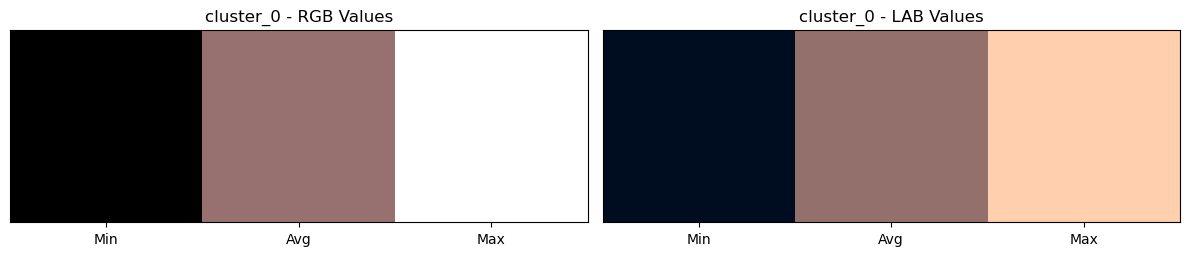

RGB Data before normalization: [[  0.           0.           0.        ]
 [145.05764249 121.65037217 129.43540681]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         110.          98.        ]
 [134.79466115 138.43929627 127.39105732]
 [255.         173.         193.        ]]


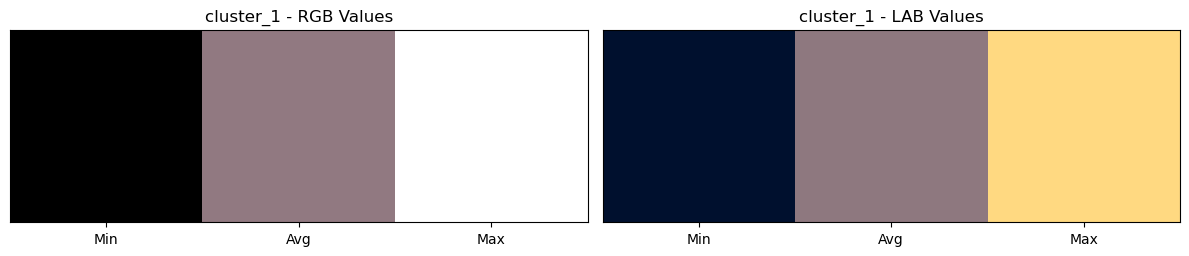

RGB Data before normalization: [[  0.           0.           0.        ]
 [171.47983942 114.81550392 121.04158893]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         113.         103.        ]
 [137.13121334 150.88564667 133.99579879]
 [255.         194.         167.        ]]


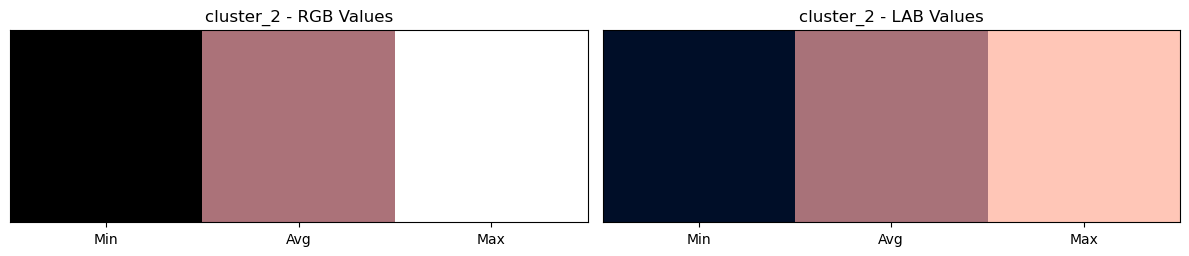

RGB Data before normalization: [[  0.           0.           0.        ]
 [210.8001953  122.46489416  79.96202248]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         114.         109.        ]
 [153.54924136 158.26529117 165.54988143]
 [255.         199.         200.        ]]


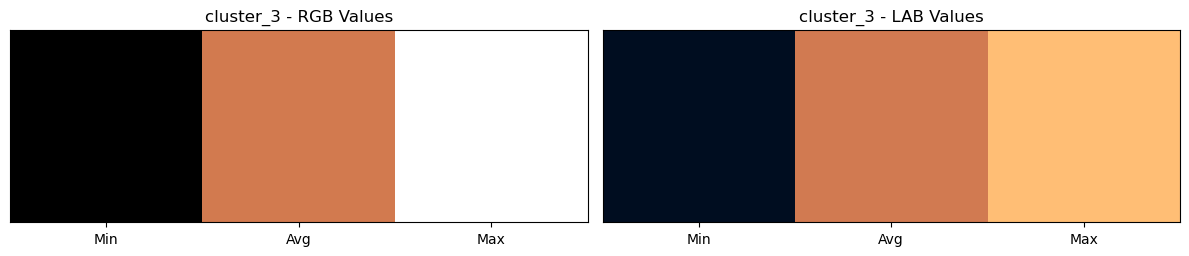

RGB Data before normalization: [[  0.           0.           0.        ]
 [150.39507592  96.92416114  86.02126987]
 [255.         255.         255.        ]]
LAB Data before conversion: [[  0.         113.         116.        ]
 [117.50594898 148.20862899 143.34790902]
 [255.         190.         193.        ]]


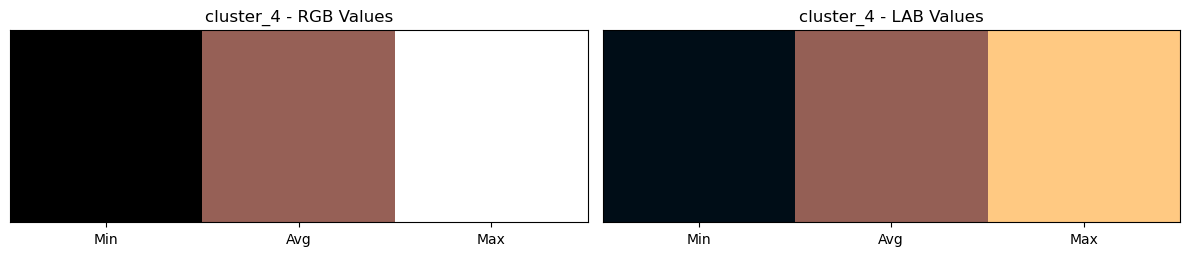

In [13]:
clusters_root_path = "clusters/5-clusters"
csv_file_path = '5_clusters_statistics_image_avg.csv'

df_stats = collect_statistics(clusters_root_path)
save_statistics_to_csv(df_stats, csv_file_path)

print(f"Statistics have been saved to {csv_file_path}")

for index, row in df_stats.iterrows():
    stats = {
        'rgb': {
            'avg': np.array([row['rgb_avg_r'], row['rgb_avg_g'], row['rgb_avg_b']]),
            'min': np.array([row['rgb_min_r'], row['rgb_min_g'], row['rgb_min_b']]),
            'max': np.array([row['rgb_max_r'], row['rgb_max_g'], row['rgb_max_b']])
        },
        'lab': {
            'avg': np.array([row['lab_avg_l'], row['lab_avg_a'], row['lab_avg_b']]),
            'min': np.array([row['lab_min_l'], row['lab_min_a'], row['lab_min_b']]),
            'max': np.array([row['lab_max_l'], row['lab_max_a'], row['lab_max_b']])
        }
    }
    visualize_cluster_stats(stats, row['cluster_name'])

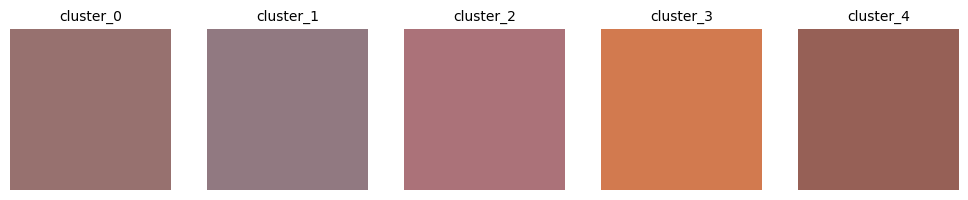

In [14]:
visualize_clusters_average_colors(df_stats)

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

def calculate_distances_to_centroids(clusters_root_path):
    distances_data = []
    
    # For each cluster directory
    for cluster_dir in Path(clusters_root_path).glob('*'):
        cluster_name = cluster_dir.name
        
        # Calculate cluster centroid from existing statistics
        centroid = df_stats[df_stats['cluster_name'] == cluster_name][['lab_avg_l', 'lab_avg_a', 'lab_avg_b']].values[0]
        
        # Process each image in cluster
        for img_path in cluster_dir.glob('*.jpg'):
            # Read and process image
            img = cv2.imread(str(img_path))
            img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            
            # Calculate average LAB values for image
            img_avg_lab = np.mean(img_lab.reshape(-1, 3), axis=0)
            
            # Calculate Euclidean distance
            distance = np.linalg.norm(img_avg_lab - centroid)
            
            distances_data.append({
                'image_name': img_path.name,
                'cluster': cluster_name,
                'centroid_distance': distance
            })
    
    return pd.DataFrame(distances_data)

# Generate and save the distances DataFrame
distances_df = calculate_distances_to_centroids(clusters_root_path)
distances_df.to_csv('cluster_distances_5.csv', index=False)


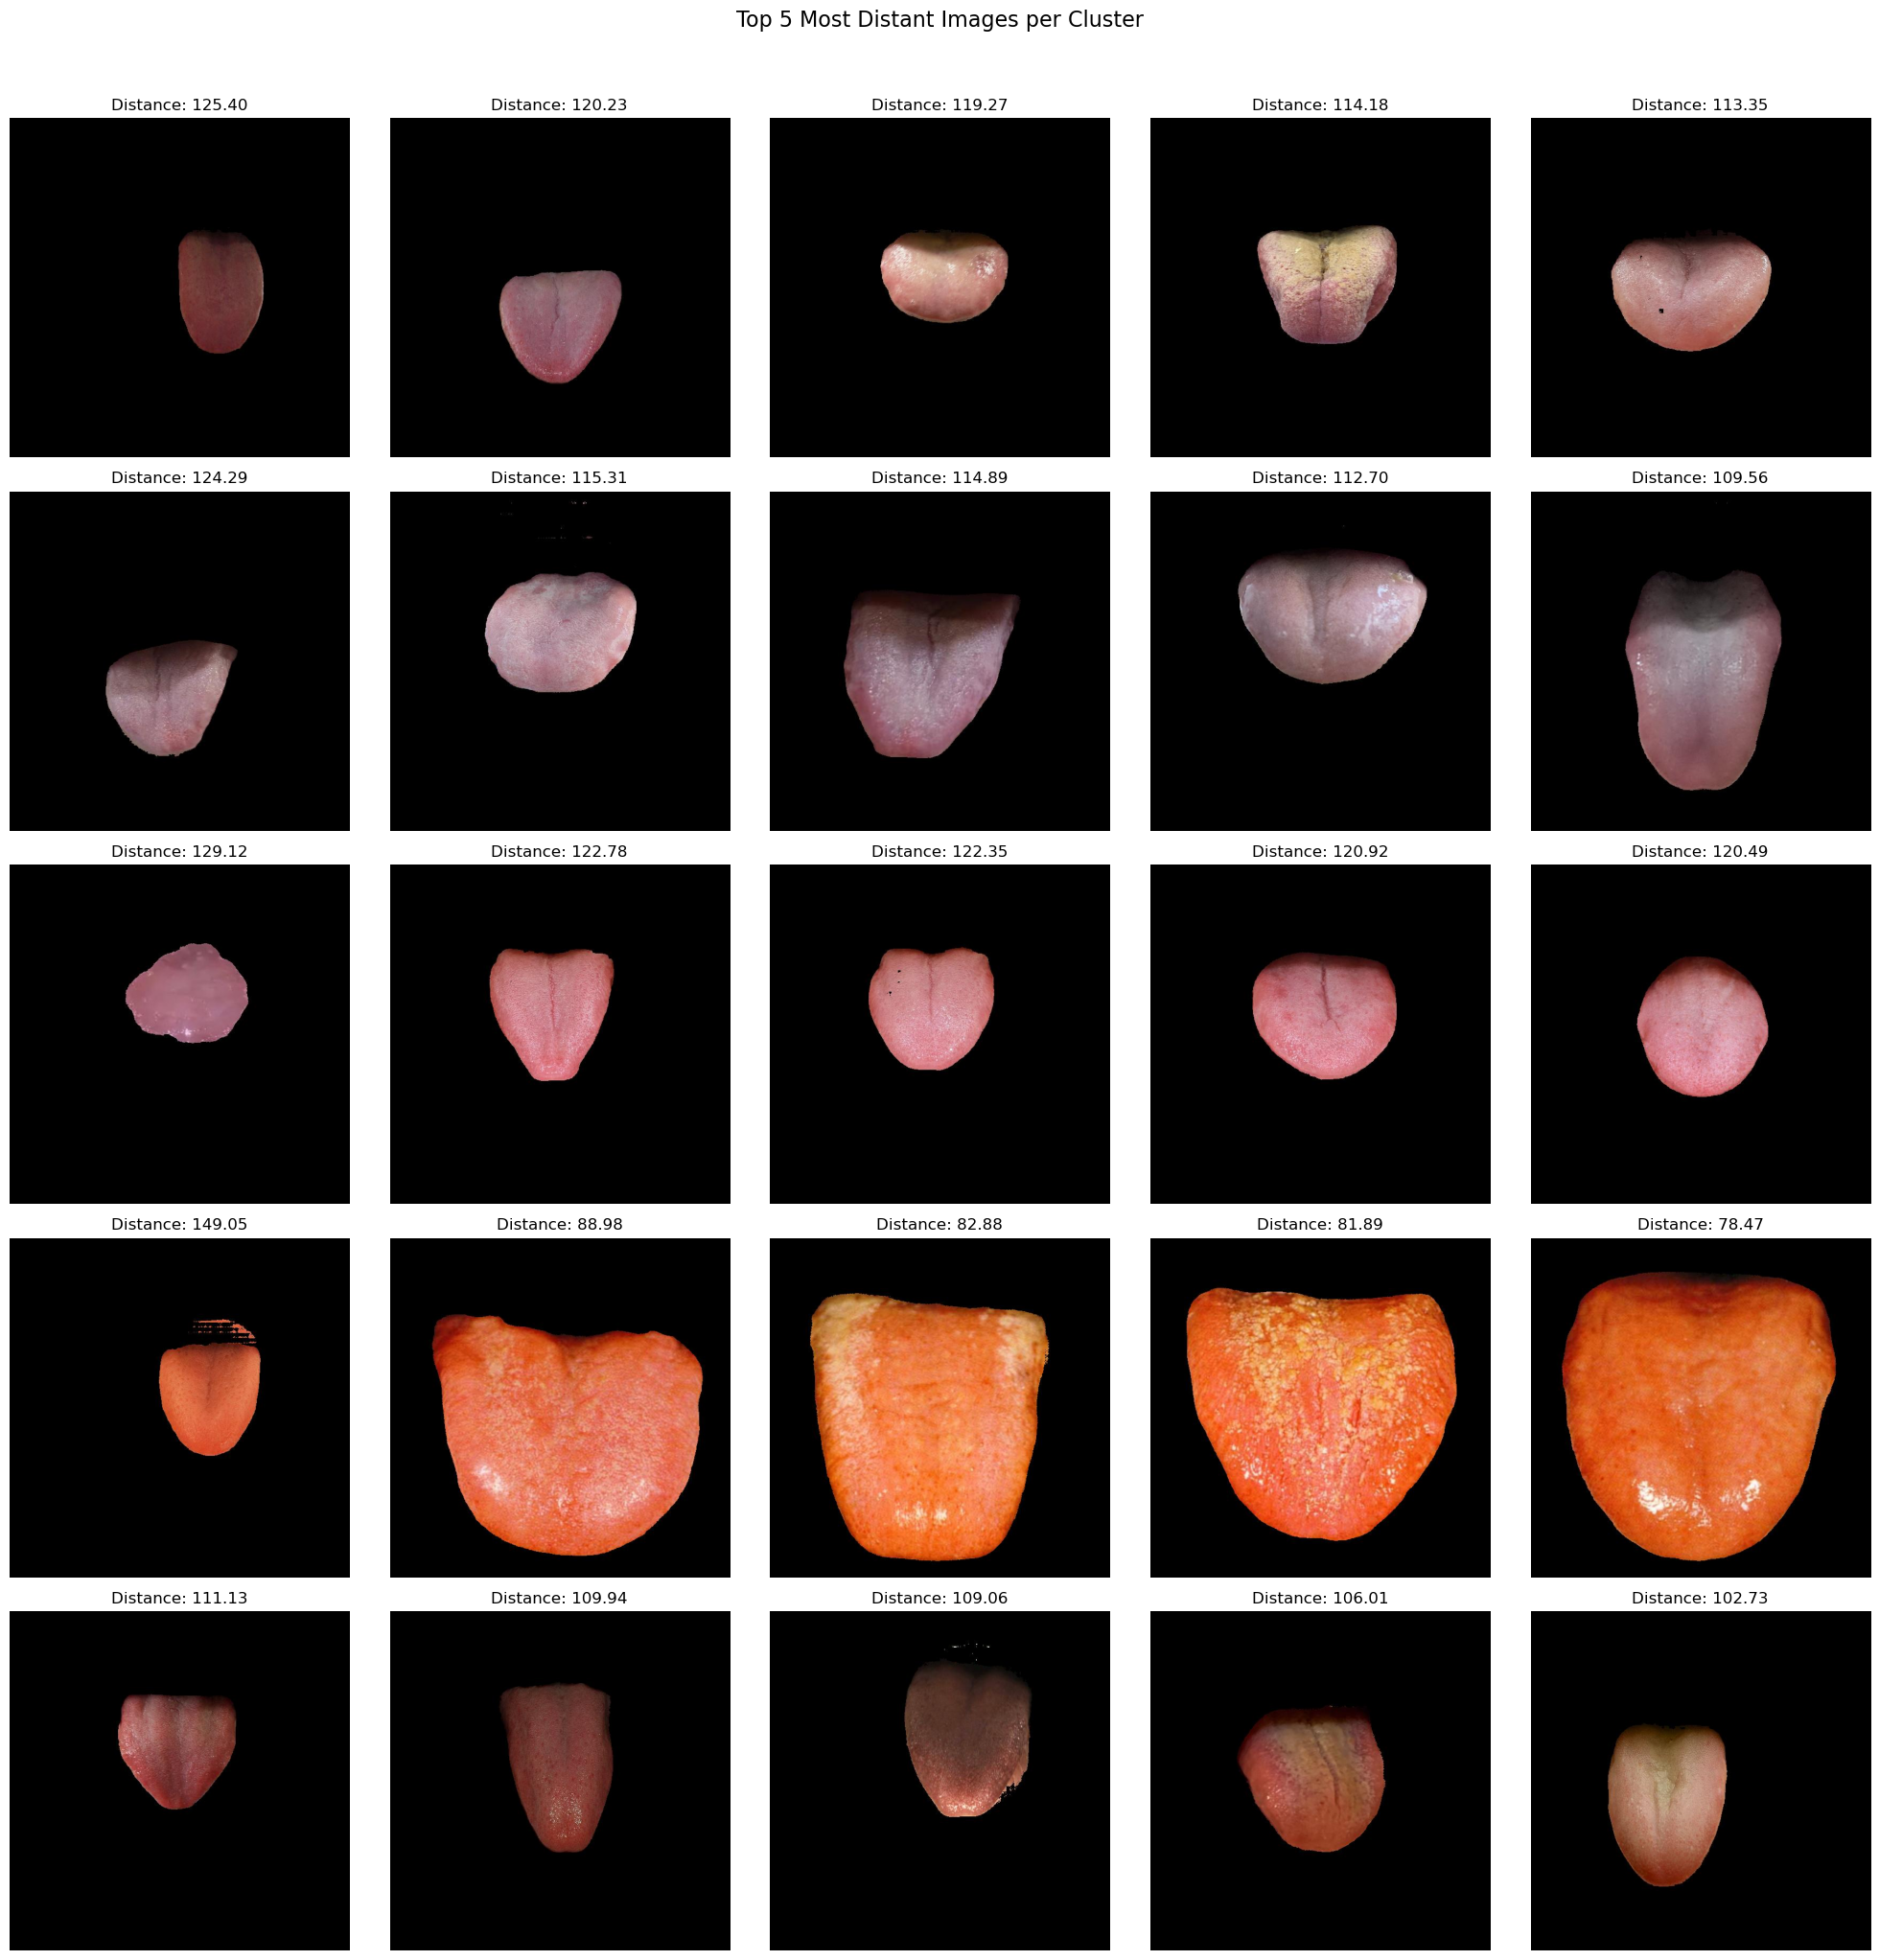

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the cluster distances
distances_df = pd.read_csv('cluster_distances_5.csv')

# Get unique clusters
clusters = distances_df['cluster'].unique()

# Create a figure with subplots for each cluster
fig, axes = plt.subplots(len(clusters), 5, figsize=(20, 4*len(clusters)))

# For each cluster
for cluster_idx, cluster in enumerate(clusters):
    # Get cluster-specific data
    cluster_data = distances_df[distances_df['cluster'] == cluster]
    
    # Get top 5 distant images for this cluster
    top_5_cluster = cluster_data.nlargest(5, 'centroid_distance')
    
    # Plot each image
    for img_idx, (_, row) in enumerate(top_5_cluster.iterrows()):
        img = plt.imread('clusters/5-clusters/' + row['cluster'] + '/' + row['image_name'])
        axes[cluster_idx, img_idx].imshow(img)
        axes[cluster_idx, img_idx].set_title(f"Distance: {row['centroid_distance']:.2f}")
        axes[cluster_idx, img_idx].axis('off')
    
plt.suptitle('Top 5 Most Distant Images per Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()